In [221]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [222]:
img1 = cv2.imread('scene1_b.jpg')
img1 = cv2.resize(img1,(800,800))
#img1 = cv2.resize(img1, (0,0), fx=0.2,fy=0.2)
img2 = cv2.imread('scene1_a.jpg')
img2 = cv2.resize(img2,(800,800))
#img2 = cv2.resize(img2, (0,0), fx=0.2,fy=0.2)

Detecting Keypoints In The Images Using SIFT

In [223]:
sift = cv2.SIFT_create()

kp1,des1 = sift.detectAndCompute(img1,None)
#simg1=cv2.drawKeypoints(img1,kp1,img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

kp2,des2 = sift.detectAndCompute(img2,None)
#simg2=cv2.drawKeypoints(img2,kp2,img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [224]:
print(len(kp1))
print(len(kp2))
print(des1.shape)
print(des2.shape)

6582
7376
(6582, 128)
(7376, 128)


In [225]:
#plt.imshow(simg1)

In [226]:
#plt.imshow(simg2)

Feature Matching

Brute-Force Matcher

In [227]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)


Applying Ratio Test

In [228]:
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.3*n.distance:
        good.append([m])

No Of Matched Keypoints

In [229]:
len(good)

66

Drawing Matches

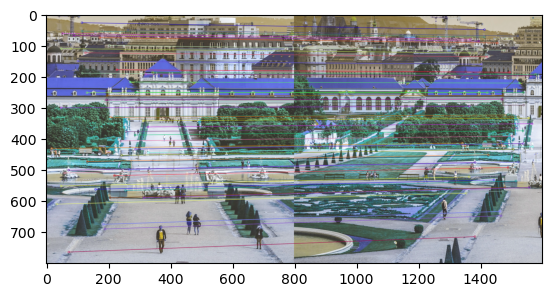

In [230]:
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

Finding Homography

In [231]:
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
    
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

In [232]:
M

array([[ 7.22628233e-01, -1.30337624e-04,  5.30272327e+02],
       [-1.38872943e-03,  9.01923937e-01,  2.47235398e+01],
       [-3.13542481e-06, -2.59892545e-08,  1.00000000e+00]])

FLANN  Based Matching

In [233]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [234]:
good = []
for m,n in matches:
    if m.distance < 0.3*n.distance:
        good.append([m])
len(good)

75

Drawing Matches

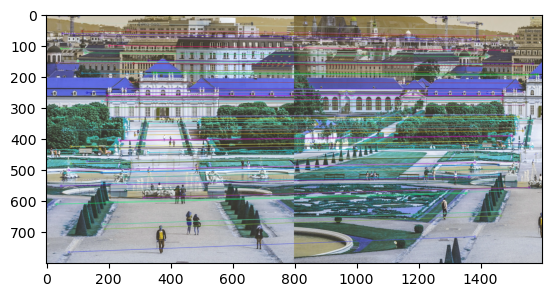

In [235]:
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

Finding Homography

In [236]:
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
    
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

In [237]:
M

array([[ 7.21589583e-01, -5.15335808e-05,  5.30347657e+02],
       [-2.03708074e-03,  9.01861643e-01,  2.48317284e+01],
       [-4.45353896e-06,  2.28886369e-07,  1.00000000e+00]])

Warping Images

In [238]:
img1 = cv2.imread('scene1_b.jpg',0)
img1 = cv2.resize(img1,(800,800))
#img1 = cv2.resize(img1, (0,0), fx=0.2,fy=0.2)
img2 = cv2.imread('scene1_a.jpg',0)
img2 = cv2.resize(img2,(800,800))
#img2 = cv2.resize(img2, (0,0), fx=0.2,fy=0.2)

Showing Overlapping Region

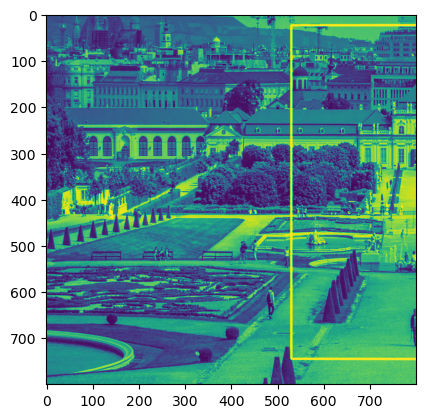

In [239]:
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
plt.imshow(img2)
plt.show()

In [240]:
img1 = cv2.imread('scene1_a.jpg')
img1 = cv2.resize(img1,(800,800))
#img1 = cv2.resize(img1, (0,0), fx=0.2,fy=0.2)
img2 = cv2.imread('scene1_b.jpg')
img2 = cv2.resize(img2,(800,800))
#img2 = cv2.resize(img2, (0,0), fx=0.2,fy=0.2)

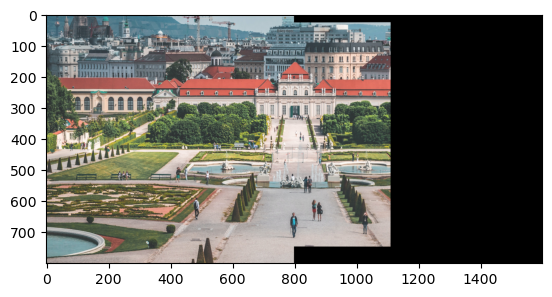

In [241]:
img1_warp = cv2.warpPerspective(img2, M, (img1.shape[1] + img2.shape[1], max(img1.shape[0],img2.shape[0])))
plt.imshow(img1_warp)
img1_warp[0:img1.shape[0], 0:img1.shape[1]] = img1
img1_warp = cv2.cvtColor(img1_warp, cv2.COLOR_BGR2RGB)
plt.imshow(img1_warp)

Post Processing

In [242]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
         frame = trim(frame[1:])
    #crop bottom
    if not np.sum(frame[-1]):
         frame = trim(frame[:-1])
    #crop left
    if not np.sum(frame[:,0]):
         frame = trim(frame[:,1:]) 
    #crop right
    if not np.sum(frame[:,-1]):
         frame = trim(frame[:,:-1])    
    return frame

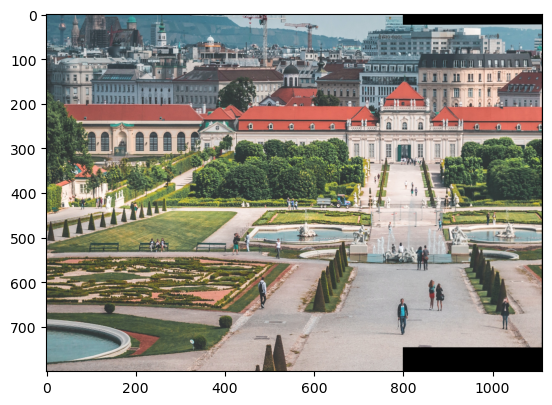

In [243]:
plt.imshow(trim(img1_warp))

In [244]:
img1_warp = cv2.cvtColor(img1_warp, cv2.COLOR_BGR2RGB)
img1_warp=trim(img1_warp)
#tag = img1[23:742,0:1109]
cv2.imwrite('first_two.jpg',img1_warp)

True

In [245]:
img1 = cv2.imread('scene1_c.jpg')
img1 = cv2.resize(img1,(800,800))
#img1 = cv2.resize(img1, (0,0), fx=0.2,fy=0.2)
img2 = cv2.imread('first_two.jpg')
img2 = cv2.resize(img2,(800,800))

In [246]:
sift = cv2.SIFT_create()

kp1,des1 = sift.detectAndCompute(img1,None)
#simg1=cv2.drawKeypoints(img1,kp1,img1,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

kp2,des2 = sift.detectAndCompute(img2,None)
#simg2=cv2.drawKeypoints(img2,kp2,img2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

In [247]:
#plt.imshow(simg1)

In [248]:
#plt.imshow(simg2)

In [249]:
# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)


In [250]:
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

In [251]:
len(good)

333

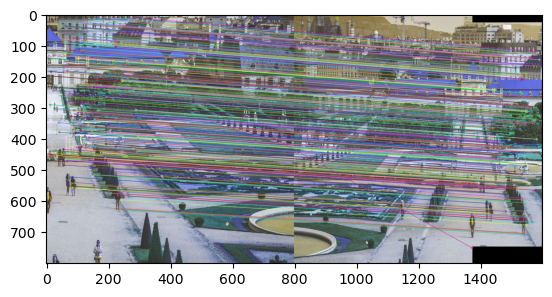

In [252]:
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

In [253]:
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
    
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
M

array([[ 7.27863243e-01, -5.86779698e-05,  5.70583338e+02],
       [-3.73019052e-03,  9.52570075e-01,  1.09085917e+02],
       [-8.34272537e-06,  1.65945560e-07,  1.00000000e+00]])

In [254]:
img1 = cv2.imread('first_two.jpg',0)
img1 = cv2.resize(img1,(800,800))
#img1 = cv2.resize(img1, (0,0), fx=0.2,fy=0.2)
img2 = cv2.imread('scene1_c.jpg',0)
img2 = cv2.resize(img2,(800,800))
#img2 = cv2.resize(img2, (0,0), fx=0.2,fy=0.2)

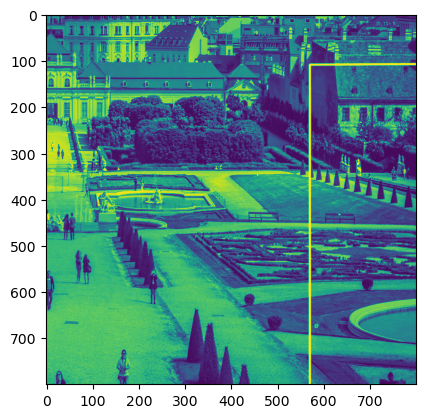

In [255]:
h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
plt.imshow(img2)
plt.show()

In [256]:
img1 = cv2.imread('first_two.jpg')
img1 = cv2.resize(img1,(800,800))
#img1 = cv2.resize(img1, (0,0), fx=0.2,fy=0.2)
img2 = cv2.imread('scene1_c.jpg')
img2 = cv2.resize(img2,(800,800))
#img2 = cv2.resize(img2, (0,0), fx=0.2,fy=0.2)

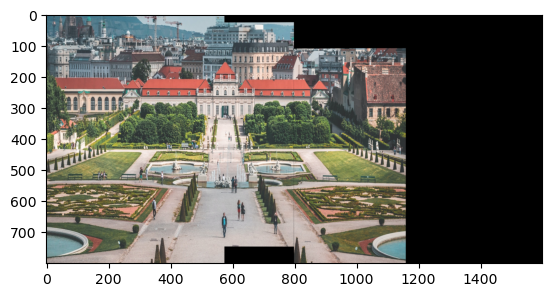

In [257]:
img1_warp = cv2.warpPerspective(img2, M, (img1.shape[1] + img2.shape[1], max(img1.shape[0],img2.shape[0])))
plt.imshow(img1_warp)
img1_warp[0:img1.shape[0], 0:img1.shape[1]] = img1
img1_warp = cv2.cvtColor(img1_warp, cv2.COLOR_BGR2RGB)
plt.imshow(img1_warp)

In [258]:
img1_warp = cv2.cvtColor(img1_warp, cv2.COLOR_BGR2RGB)
img1_warp=trim(img1_warp)
tag = img1_warp[110:742,0:1109]
cv2.imwrite('result.jpg',tag)

True

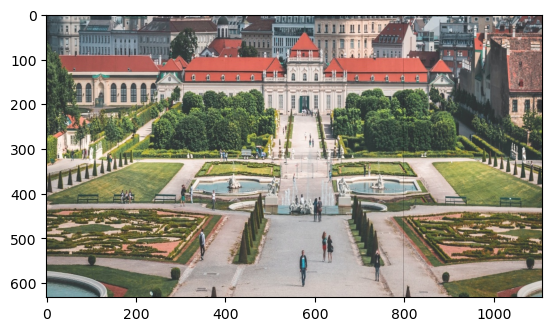

In [259]:
img1 = cv2.imread('result.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)

PostProcessing

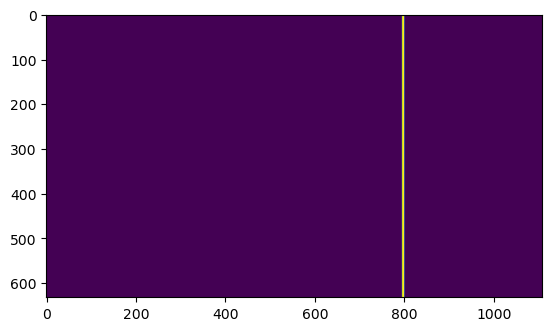

In [262]:
height = img1.shape[0]
width = img1.shape[1]
polygon = np.array([[(796, height),(800, height),(800,0), (796,0)]])
mask = np.zeros_like(img1)
mask = cv2.fillPoly(mask,polygon,255)
mask2 = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
plt.imshow(mask2)

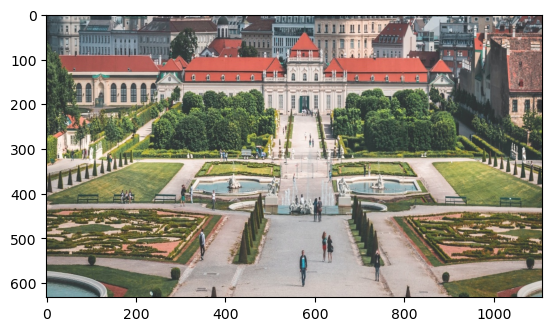

In [263]:
dst = cv2.inpaint(img1,mask2,3,cv2.INPAINT_TELEA)
plt.imshow(dst)

In [265]:
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
cv2.imwrite('final_result.jpg',dst)

True